In [1]:
# flatten data

In [2]:
import pandas as pd

from gradecc.compute.conn_mat import ConnectivityMatrixMean
from gradecc.load_data.subject import SUBJECTS_INT

In [3]:
from tqdm import tqdm

In [4]:
E = ['rest', 'baseline', 'early', 'late']

In [5]:
conn_mat = {s: {} for s in SUBJECTS_INT}
for s in tqdm(SUBJECTS_INT):
    for e in E:
        c = ConnectivityMatrixMean(epoch=e, subjects=s, kind='covariance')
        c.load()
        conn_mat[s][e] = c.data

100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


In [6]:
# for subject s, epoch e
# conn_mat[s][e]

In [7]:
conn_mat_flat = {s: {} for s in SUBJECTS_INT}
for s in tqdm(SUBJECTS_INT):
    for e in E:
        conn_mat_flat[s][e] = conn_mat[s][e].flatten()

100%|██████████| 38/38 [00:00<00:00, 102.04it/s]


In [8]:
import numpy as np

def stack(mat):
    return np.vstack([
        np.stack([
            mat[s][e]
            for e in E
        ])
        for s in SUBJECTS_INT
    ])

In [9]:
conn_mat_stacked = stack(conn_mat)
conn_mat_stacked.shape

(152, 1040, 1040)

In [10]:
conn_mat_flat_stacked = stack(conn_mat_flat)
conn_mat_flat_stacked.shape

(152, 1081600)

In [11]:
# umap

In [12]:
import umap

reducer = umap.UMAP(random_state=42)

In [13]:
embedding1 = reducer.fit_transform(conn_mat_flat_stacked)
embedding1.shape

(152, 2)

In [14]:
s_e = [[s, e] for s in SUBJECTS_INT for e in E]
s_e = pd.DataFrame(s_e, columns=['subject_int', 'epoch'])
s_e

,subject_int,epoch
0,1,rest
1,1,baseline
2,1,early
3,1,late
4,2,rest
...,...,...
147,45,late
148,46,rest
149,46,baseline
150,46,early


In [15]:
emb1 = pd.DataFrame(embedding1, columns=['e1', 'e2'])
emb1 = pd.concat([s_e, emb1], axis=1)

In [16]:
# plot 2d

In [79]:
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

<AxesSubplot:xlabel='e1', ylabel='e2'>

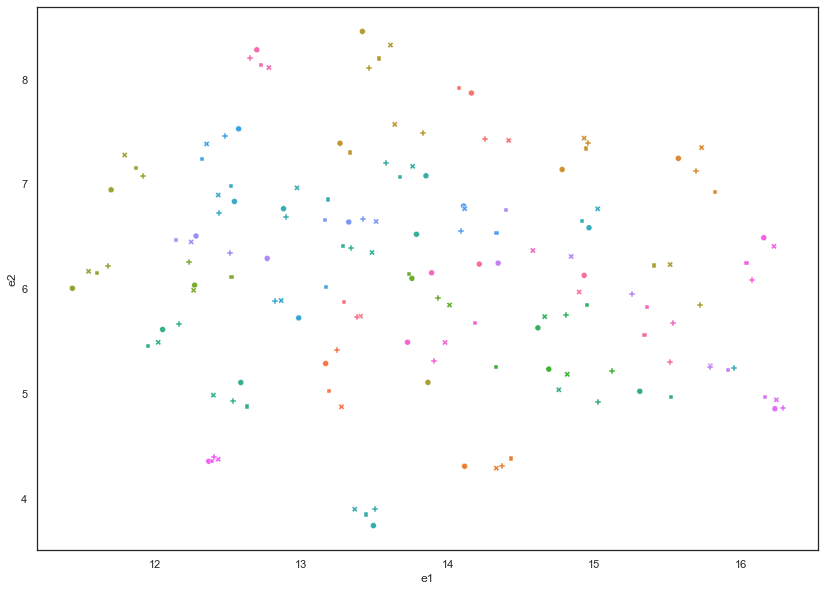

In [80]:
sns.scatterplot(data=emb1.astype({'subject_int': str}),
                x='e1', y='e2',
                hue='subject_int', style='epoch',
                legend=False)

In [19]:
# subject mean

In [20]:
conn_mat_subj_mean = {}
for s in SUBJECTS_INT:
    conn_mat_subj_mean[s] = np.stack([
        conn_mat[s][e] for e in E
             ]).mean(axis=0)

In [21]:
# pyriemann centering

In [22]:
from pyriemann.utils.mean import mean_riemann

In [23]:
conn_mat[1]['rest']

array([[ 1.09106973e+00,  8.08275453e-01,  7.64381614e-01, ...,
         1.99167726e-01,  3.55835010e-02,  1.47145848e-01],
       [ 8.08275453e-01,  1.19138871e+00,  7.94481668e-01, ...,
         2.64693018e-01,  3.37206399e-04,  2.60569249e-01],
       [ 7.64381614e-01,  7.94481668e-01,  1.11792967e+00, ...,
         1.88591837e-01, -4.46409578e-02,  9.67747676e-02],
       ...,
       [ 1.99167726e-01,  2.64693018e-01,  1.88591837e-01, ...,
         1.15254861e+00,  2.78588026e-01,  5.53784333e-01],
       [ 3.55835010e-02,  3.37206399e-04, -4.46409578e-02, ...,
         2.78588026e-01,  1.09703199e+00,  2.86946637e-01],
       [ 1.47145848e-01,  2.60569249e-01,  9.67747676e-02, ...,
         5.53784333e-01,  2.86946637e-01,  1.07256715e+00]])

In [24]:
all_cmats = conn_mat_stacked
all_cmats.shape
from gradecc.load_data import Timeseries

ts = Timeseries(epoch=E[0], subject_id=SUBJECTS_INT[0])
ts.load()
region_names = ts.region_names
roi_labels = region_names
all_cmats.shape

(152, 1040, 1040)

In [25]:
# import pickle
#
# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(all_cmats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     all_cmats = pickle.load(handle)

In [26]:
# should not fill diag with 0 to compute mean riemann

In [27]:
from pyriemann.utils.mean import mean_riemann

grand_mean = mean_riemann(all_cmats, maxiter=5)

In [28]:
grand_mean

array([[0.16351544, 0.01311222, 0.01344567, ..., 0.00373861, 0.00201097,
        0.00405588],
       [0.01311222, 0.15676097, 0.0219036 , ..., 0.00552269, 0.00245842,
        0.00541435],
       [0.01344567, 0.0219036 , 0.1605061 , ..., 0.0054473 , 0.00234032,
        0.00483201],
       ...,
       [0.00373861, 0.00552269, 0.0054473 , ..., 0.52021354, 0.06646739,
        0.13679602],
       [0.00201097, 0.00245842, 0.00234032, ..., 0.06646739, 0.53588015,
        0.05557587],
       [0.00405588, 0.00541435, 0.00483201, ..., 0.13679602, 0.05557587,
        0.51904623]])

In [29]:
# save grand_mean
df = pd.DataFrame(grand_mean, index=roi_labels, columns=roi_labels)
df.to_csv('grand_mean.tsv', sep='\t')

In [39]:
conn_mat[1].values()

dict_values([array([[ 1.09106973e+00,  8.08275453e-01,  7.64381614e-01, ...,
         1.99167726e-01,  3.55835010e-02,  1.47145848e-01],
       [ 8.08275453e-01,  1.19138871e+00,  7.94481668e-01, ...,
         2.64693018e-01,  3.37206399e-04,  2.60569249e-01],
       [ 7.64381614e-01,  7.94481668e-01,  1.11792967e+00, ...,
         1.88591837e-01, -4.46409578e-02,  9.67747676e-02],
       ...,
       [ 1.99167726e-01,  2.64693018e-01,  1.88591837e-01, ...,
         1.15254861e+00,  2.78588026e-01,  5.53784333e-01],
       [ 3.55835010e-02,  3.37206399e-04, -4.46409578e-02, ...,
         2.78588026e-01,  1.09703199e+00,  2.86946637e-01],
       [ 1.47145848e-01,  2.60569249e-01,  9.67747676e-02, ...,
         5.53784333e-01,  2.86946637e-01,  1.07256715e+00]]), array([[ 1.00787953,  0.23300753,  0.50633092, ...,  0.04168037,
        -0.12909226,  0.032568  ],
       [ 0.23300753,  1.00791613,  0.23761153, ...,  0.06854963,
        -0.1366801 ,  0.1801675 ],
       [ 0.50633092,  0.23761

In [46]:
from tqdm import tqdm

subject_riemann_mean = {}
for s in tqdm(SUBJECTS_INT):
    subject_riemann_mean[s] = mean_riemann(np.stack(conn_mat[s].values()), maxiter=10)

100%|██████████| 38/38 [24:08<00:00, 38.13s/it]


In [57]:
conn_mat_centered = {}
for s in tqdm(SUBJECTS_INT):
    conn_mat_centered[s] = {
        e: center_cmat(conn_mat[s][e], subject_riemann_mean[s], grand_mean)
        for e in E
    }

100%|██████████| 38/38 [10:16<00:00, 16.22s/it]


In [59]:
conn_mat_centered[1]['early'].shape

(1040, 1040)

In [60]:
conn_mat[1]['early'].shape

(1040, 1040)

In [50]:
from pyriemann.utils.base import sqrtm, logm, expm, invsqrtm

def center_cmat(c, sub_mean, grand_mean):
    """Center covariance matrix using tangent transporting procedure

    Parameters
    ----------
    c : numpy.ndarray
        Single MxM covariance matrix of a single subject
    sub_mean : numpy.ndarray
        Geometric mean covariance matrix of the subject
    grand_mean : numpy.ndarray
        Geometric mean across all subjects and matrices

    Returns
    -------
    numpy.ndarray
        Centered covariance matrix
    """
    t = _to_tangent(c, sub_mean)
    tc = _gl_transport(t, sub_mean, grand_mean)
    return _from_tangent(tc, grand_mean)


# Covariance centering
def _to_tangent(s, mean):
    p = sqrtm(mean)
    p_inv = invsqrtm(mean)
    return p @ logm(p_inv @ s @ p_inv) @ p


def _gl_transport(t, sub_mean, grand_mean):
    g = sqrtm(grand_mean) @ invsqrtm(sub_mean)
    return g @ t @ g.T


def _from_tangent(t, grand_mean):
    p = sqrtm(grand_mean)
    p_inv = invsqrtm(grand_mean)
    return p @ expm(p_inv @ t @ p_inv) @ p


In [65]:
conn_mat_centered_flat = {s: {} for s in SUBJECTS_INT}
for s in tqdm(SUBJECTS_INT):
    for e in E:
        conn_mat_centered_flat[s][e] = conn_mat_centered[s][e].flatten()

100%|██████████| 38/38 [00:02<00:00, 18.57it/s]


In [66]:
# umap centered
reducer = umap.UMAP(random_state=42)
embedding2 = reducer.fit_transform(stack(conn_mat_centered_flat))
embedding2.shape

(152, 2)

In [75]:
emb2 = pd.DataFrame(embedding2, columns=['e1', 'e2'])
emb2 = pd.concat([s_e, emb2], axis=1)

In [73]:
# plot 2d

In [76]:
emb2

,subject_int,epoch,e1,e2
0,1,rest,0.517405,6.417356
1,1,baseline,-1.939326,5.998337
2,1,early,-2.804951,6.748304
3,1,late,-3.320396,6.831932
4,2,rest,-2.365642,4.598580
...,...,...,...,...
147,45,late,-2.749221,5.624915
148,46,rest,-2.081504,5.421144
149,46,baseline,-2.598400,5.477745
150,46,early,-0.040650,7.291835


<AxesSubplot:xlabel='e1', ylabel='e2'>

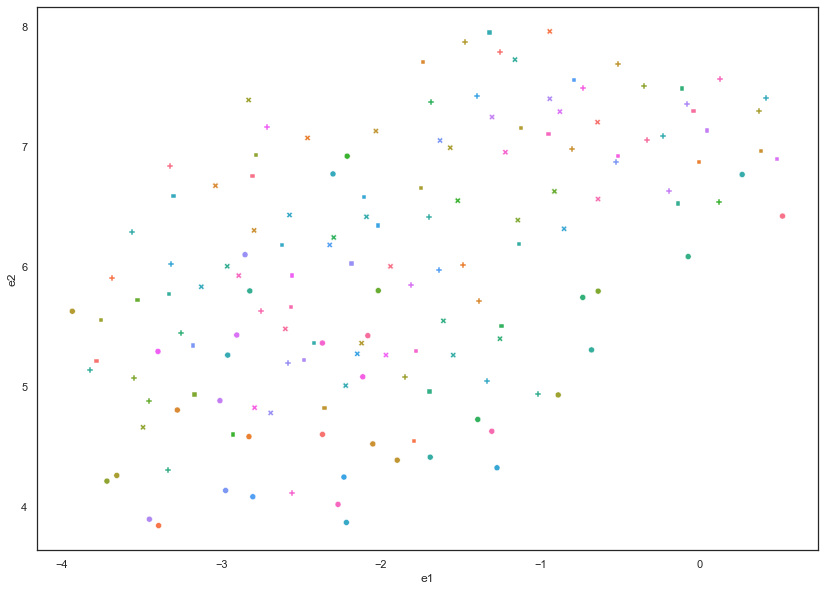

In [81]:
sns.scatterplot(data=emb2.astype({'subject_int': str}),
                x='e1', y='e2',
                hue='subject_int', style='epoch',
                legend=False)

In [ ]:
# save data

In [92]:
from gradecc.utils.filenames import dir_cache
import pickle

def dump_pkl(obj, fname):
    with open(dir_cache+fname +'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

# def dump_pkl(obj, fname):
#     with open('data/filename.pickle', 'rb') as handle:
#         all_cmats = pickle.load(handle)

In [93]:
dump_pkl(conn_mat, 'conn_mat')
dump_pkl(conn_mat_centered, 'conn_mat_centered')
dump_pkl(subject_riemann_mean, 'subject_riemann_mean')
dump_pkl(grand_mean, 'grand_mean')